In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam , SGD
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , confusion_matrix
from keras.callbacks import LearningRateScheduler
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import math
from imutils import paths
import pandas as pd
import numpy as np
from itertools import chain
import os
import cv2
from PIL import Image
import pickle
import random

plt.style.use("ggplot")

In [ ]:
# pickle_in = open("/content/drive/MyDrive/Datasets/PetImages/X-pretrained.pickle" , "rb")
# X = pickle.load(pickle_in)
# pickle_in = open("/content/drive/MyDrive/Datasets/PetImages/y-pretrained.pickle" , "rb")
# y = pickle.load(pickle_in)

In [ ]:
# X_preprocessed = []
# y_preprocessed = []
# for img , label in zip(X , y):
#   y_preprocessed.append(label)
#   image = img_to_array(img)
#   image = preprocess_input(image)
#   X_preprocessed.append(image)

In [ ]:
path = ["/PetImages/Cat",
         "/PetImages/Dog"]

imagePaths = []
for i in path:
  imagePaths.append(list(paths.list_images(i)))
imagePaths = list(chain.from_iterable(imagePaths))      # converting a 2D list into 1D list

In [ ]:
imagePaths[:5]

['/content/drive/MyDrive/Datasets/PetImages/Cat/1904.jpg',
 '/content/drive/MyDrive/Datasets/PetImages/Cat/1869.jpg',
 '/content/drive/MyDrive/Datasets/PetImages/Cat/1893.jpg',
 '/content/drive/MyDrive/Datasets/PetImages/Cat/1865.jpg',
 '/content/drive/MyDrive/Datasets/PetImages/Cat/1875.jpg']

In [ ]:
imagePaths[-5:]

['/content/drive/MyDrive/Datasets/PetImages/Dog/10.jpg',
 '/content/drive/MyDrive/Datasets/PetImages/Dog/100.jpg',
 '/content/drive/MyDrive/Datasets/PetImages/Dog/1004.jpg',
 '/content/drive/MyDrive/Datasets/PetImages/Dog/1005.jpg',
 '/content/drive/MyDrive/Datasets/PetImages/Dog/1002.jpg']

In [ ]:
data = []
labels = []
for i in imagePaths:
  try:
    image = load_img(i , target_size = (224 , 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)
    label = i.split(os.path.sep)[-2]
    labels.append(label)
  except Exception as e:
    pass

In [ ]:
data = np.array(data , dtype = "float32")
labels = np.array(labels)

In [ ]:
# plt.imshow(data[2500])

In [ ]:
labels

array(['Cat', 'Cat', 'Cat', ..., 'Dog', 'Dog', 'Dog'], dtype='<U3')

In [ ]:
def plotBarchart(array , figsize = (7 , 7)):
  labels_series = pd.Series(labels)
  ds = labels_series.value_counts().reset_index()      
  ds.columns = ["Name" , "Count"]
  ds["Name"] = ds["Name"].astype("object")

  fig , ax = plt.subplots(figsize = figsize)
  ax = sns.barplot(x = "Name" , y = "Count" , data = ds)
  plt.grid(False)

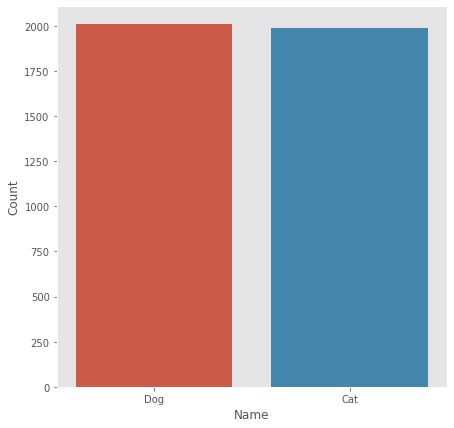

In [ ]:
plotBarchart(labels)

In [ ]:
print("X shape : " , data.shape)
print("y shape : " , labels.shape)

X shape :  (3996, 224, 224, 3)
y shape :  (3996,)


In [ ]:
X_train , X_test , y_train , y_test = train_test_split(data , labels , test_size = .25 , random_state = 1 , stratify = labels , shuffle = True)

In [ ]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = lb.fit_transform(y_test)
y_test = to_categorical(y_test)

In [ ]:
print("X_train shape : " , X_train.shape)
print("y_train shape : " , y_train.shape)
print("X_test shape : " , X_test.shape)
print("y_test shape : " , y_test.shape)

X_train shape :  (2997, 224, 224, 3)
y_train shape :  (2997, 2)
X_test shape :  (999, 224, 224, 3)
y_test shape :  (999, 2)


In [ ]:
y_train[44]

array([1., 0.], dtype=float32)

In [ ]:
label_dict = {0 : "Cat" , 1 : "Dog"}

In [ ]:
train_datagen = ImageDataGenerator(
                         rotation_range = 20,
                         zoom_range = 0.15,
                         width_shift_range = 0.2,
                         shear_range = 0.15,
                         horizontal_flip = True,
                         vertical_flip = True, 
                         fill_mode = "nearest"
                        )
# test_datagen = ImageDataGenerator(rescale = 1.0 / 255.0)

In [ ]:
baseModel = MobileNetV2(weights = "imagenet" , include_top = False , input_tensor = Input(shape = (224 , 224 , 3)))

In [ ]:
baseModel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size = (7 , 7))(headModel)
headModel = Flatten(name = "Flatten")(headModel)
headModel = Dense(128 , activation = "relu")(headModel)
headModel = Dropout(rate = 0.1)(headModel)
headModel = Dense(2 , activation = "softmax")(headModel)

model = Model(inputs = baseModel.input  , outputs = headModel)

In [ ]:
for layer in baseModel.layers:
  layer.trainable = False

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [ ]:
class learning_rate_schedule():
  def plot(self, epochs, title="Learning Rate Schedule"):

    lrs = [self(i) for i in epochs]
    plt.figure()
    plt.plot(epochs, lrs)
    plt.title(title)
    plt.xlabel("Epoch #")
    plt.ylabel("Learning Rate")
    plt.show()


class step_decay(learning_rate_schedule):
  def __init__(self, initAlpha = 0.001 , factor = 0.25 , dropEvery = 10):
    self.initAlpha = initAlpha
    self.factor = factor
    self.dropEvery = dropEvery

  def __call__(self, epoch):
    # compute the learning rate for the current epoch
    exp = np.floor((1 + epoch) / self.dropEvery)
    alpha = self.initAlpha * (self.factor ** exp)
    # return the learning rate
    print(alpha)
    return float(alpha)

class polynomial_decay(learning_rate_schedule):
	def __init__(self, maxEpochs=20, initAlpha=0.001, power=1.0):
   
		# store the maximum number of epochs, base learning rate,
		# and power of the polynomial
		self.maxEpochs = maxEpochs
		self.initAlpha = initAlpha
		self.power = power
	def __call__(self, epoch):
		# compute the new learning rate based on polynomial decay
		decay = (1 - (epoch / float(self.maxEpochs))) ** self.power
		alpha = self.initAlpha * decay
		# return the new learning rate
		return float(alpha)

In [ ]:
schedule = "step_decay"

if schedule == "linear":
  schedule = polynomial_decay(maxEpochs = 30 , initAlpha = 0.001 , power = 1.0)

if schedule == "polynomial":
  schedule = polynomial_decay(maxEpochs = 30 , initAlpha = 0.001 , power = 3.0)

if schedule == "step_decay":
  schedule = step_decay(initAlpha = 0.001 , factor = 0.25 , dropEvery = 5)

In [ ]:
LEARNING_RATE = 0.001
EPOCHS = 10
BS = 24
OPT = Adam(lr = LEARNING_RATE)

In [ ]:
lrate = LearningRateScheduler(schedule)
callbacks_list = [lrate]

In [ ]:
model.compile(loss = "binary_crossentropy" , optimizer = OPT , metrics = ["accuracy"])

In [ ]:
r = model.fit(
    train_datagen.flow(X_train , y_train , batch_size = BS),
    steps_per_epoch = len(X_train) // BS,
    validation_data = (X_test , y_test),
    epochs = EPOCHS
)

Epoch 1/10
124/124 [==============================] - 34s 239ms/step - loss: 0.2676 - accuracy: 0.8840 - val_loss: 0.0610 - val_accuracy: 0.9780
Epoch 2/10
124/124 [==============================] - 29s 230ms/step - loss: 0.1719 - accuracy: 0.9324 - val_loss: 0.0599 - val_accuracy: 0.9800
Epoch 3/10
124/124 [==============================] - 28s 227ms/step - loss: 0.1395 - accuracy: 0.9457 - val_loss: 0.0703 - val_accuracy: 0.9780
Epoch 4/10
124/124 [==============================] - 28s 225ms/step - loss: 0.1219 - accuracy: 0.9509 - val_loss: 0.0641 - val_accuracy: 0.9770
Epoch 5/10
124/124 [==============================] - 28s 225ms/step - loss: 0.1185 - accuracy: 0.9537 - val_loss: 0.0831 - val_accuracy: 0.9700
Epoch 6/10
124/124 [==============================] - 28s 224ms/step - loss: 0.1149 - accuracy: 0.9563 - val_loss: 0.0592 - val_accuracy: 0.9790
Epoch 7/10
124/124 [==============================] - 28s 225ms/step - loss: 0.1016 - accuracy: 0.9572 - val_loss: 0.0692 - val_ac

0.001
0.001
0.001
0.001
0.00025
0.00025
0.00025
0.00025
0.00025
6.25e-05


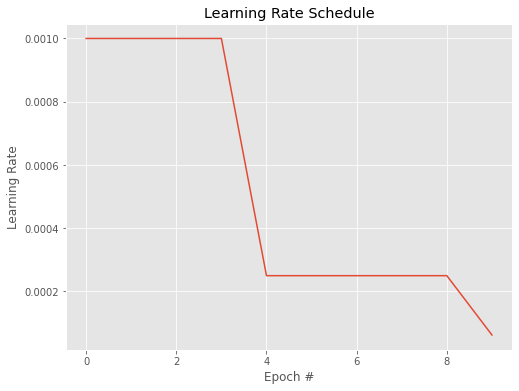

In [ ]:
N = np.arange(0, EPOCHS)

plt.rcParams["figure.figsize"] = 8 , 6
schedule.plot(N)
plt.show()

In [ ]:
# model.save("models/mobilenetv2-model/cats-dogs-pretrained-model.model")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/My Projects/Cats Dogs Classification/MobileNet Model/cats-dogs-pretrained-model.model/assets


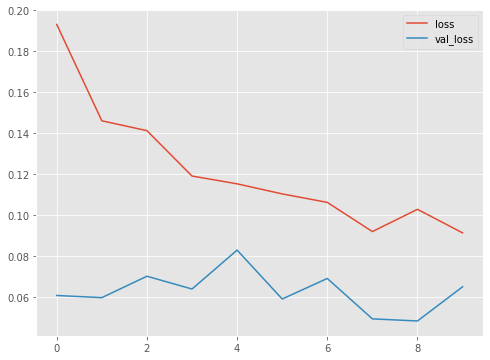

In [ ]:
plt.rcParams["figure.figsize"] = 8 , 6
plt.plot(r.history["loss"] , label = "loss")
plt.plot(r.history["val_loss"] , label = "val_loss")
plt.grid(True)
plt.legend()

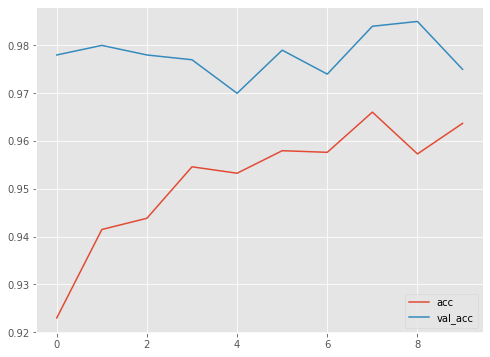

In [ ]:
plt.rcParams["figure.figsize"] = 8 , 6
plt.plot(r.history["accuracy"] , label = "acc")
plt.plot(r.history["val_accuracy"] , label = "val_acc")
plt.grid(True)
plt.legend()

In [ ]:
prediction = model.predict(X_test , batch_size = BS).argmax(axis = 1)

In [ ]:
prediction

array([1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,

In [ ]:
y_test

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [ ]:
print(classification_report(y_test.argmax(axis = 1) , prediction))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       497
           1       0.96      0.99      0.98       502

    accuracy                           0.97       999
   macro avg       0.98      0.97      0.97       999
weighted avg       0.98      0.97      0.97       999



In [ ]:
label_dict = {0 :"Cat" , 1 : "Dog"}

In [ ]:
import itertools
def plot_confusion_matrix(cm , classes , title = "Confusion Matrix" , figsize = (5 ,5) , cmap = plt.cm.Blues):
  
  print(cm)
  
  fig , ax = plt.subplots(figsize = figsize)
  im = ax.imshow(cm ,  interpolation = "nearest" , cmap = cmap)
  ax.set_title(title)
  fig.colorbar(im)
  tick_marks = np.arange(len(classes))
  ax.set_xticks(tick_marks)
  ax.set_yticks(tick_marks)

  thresh = cm.max() / 2
  for i , j in itertools.product(range(cm.shape[0]) , range(cm.shape[1])):
    plt.text(j , i , format(cm[i , j] , "d") , horizontalalignment = "center", 
              color = "white" if cm[i , j] > thresh else "black")
          
  plt.tight_layout()
  plt.ylabel("True Label")
  plt.xlabel("Predicted Label")
  ax.set_xticklabels(label_dict.values())
  ax.set_yticklabels(label_dict.values()) 
  plt.grid(False)
  plt.show()

In [ ]:
cm = confusion_matrix(y_test.argmax(axis = 1), prediction)

[[475  22]
 [  3 499]]


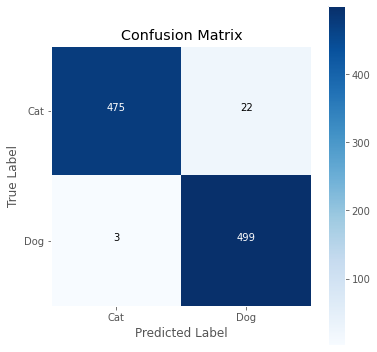

In [ ]:
plot_confusion_matrix(cm , classes = list(range(2)))

In [ ]:
y_testFlattened = []
for i in range(len(y_test)):
  y_testFlattened.append(y_test[i][1]) 
y_testFlattened = np.array(y_testFlattened , dtype = "int")

In [ ]:
def plotClassified(X_test , predict , y_test , figsize = (15 , 15) , wspace = 0.1  , hspace = 0.3):
  plt.rcParams["axes.grid"] = True
  plt.rcParams["axes.edgecolor"] = "0.15"                 # selecting edge/border color for each image
  plt.rcParams["axes.linewidth"]  = 1.25                  # assining a edge/border width for each image

  fig , axes = plt.subplots(3 , 3 , figsize = figsize)
  plt.subplots_adjust(wspace = wspace , hspace = hspace)        # determining the width gap and height gap between each subplots

  axes = axes.flatten()                                   # for using axes indeces with one dimention array instead of two dimension

  for i in range(0 , 9):
    classified_idx = np.where(predict == y_test)[0]    # representing misclassified images
    n = np.random.choice(classified_idx)
    img = np.reshape(X_test[n], (224 , 224 , 3))                # converting a 1-D array into 2-D 224x224 array
    axes[i].imshow(img , cmap = "gray")
    axes[i].title.set_text("True label : {} , predicted : {}".format(label_dict[y_testFlattened[n]] , label_dict[predict[n]]))
    axes[i].tick_params(labelbottom = False , labelleft = False)    # removing labels/ticks along x axis and y axis
    axes[i].grid(False)

In [ ]:
def plotMisclassified(X_test , predict , y_test , figsize = (15 , 15) , wspace = 0.1  , hspace = 0.3):
  
  try:
    plt.rcParams["axes.grid"] = True
    plt.rcParams["axes.edgecolor"] = "0.15"                 # selecting edge/border color for each image
    plt.rcParams["axes.linewidth"]  = 1.25                  # assining a edge/border width for each image

    fig , axes = plt.subplots(3 , 3 , figsize = figsize)
    plt.subplots_adjust(wspace = wspace , hspace = hspace)        # determining the width gap and height gap between each subplots

    axes = axes.flatten()                                   # for using axes indeces with one dimention array instead of two dimension

    for i in range(0 , 9):
      classified_idx = np.where(predict != y_test)[0]    # representing misclassified images
      n = np.random.choice(classified_idx)
      img = np.reshape(X_test[n], (224 , 224 , 3))                # converting a 1-D array into 2-D 224x224 array
      axes[i].imshow(img, cmap = "gray")
      axes[i].title.set_text("True label : {} , predicted : {}".format(label_dict[y_testFlattened[n]] , label_dict[predict[n]]))
      axes[i].tick_params(labelbottom = False , labelleft = False)    # removing labels/ticks along x axis and y axis
      axes[i].grid(False)
  except:
    print("There is nothing to plot here...")  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


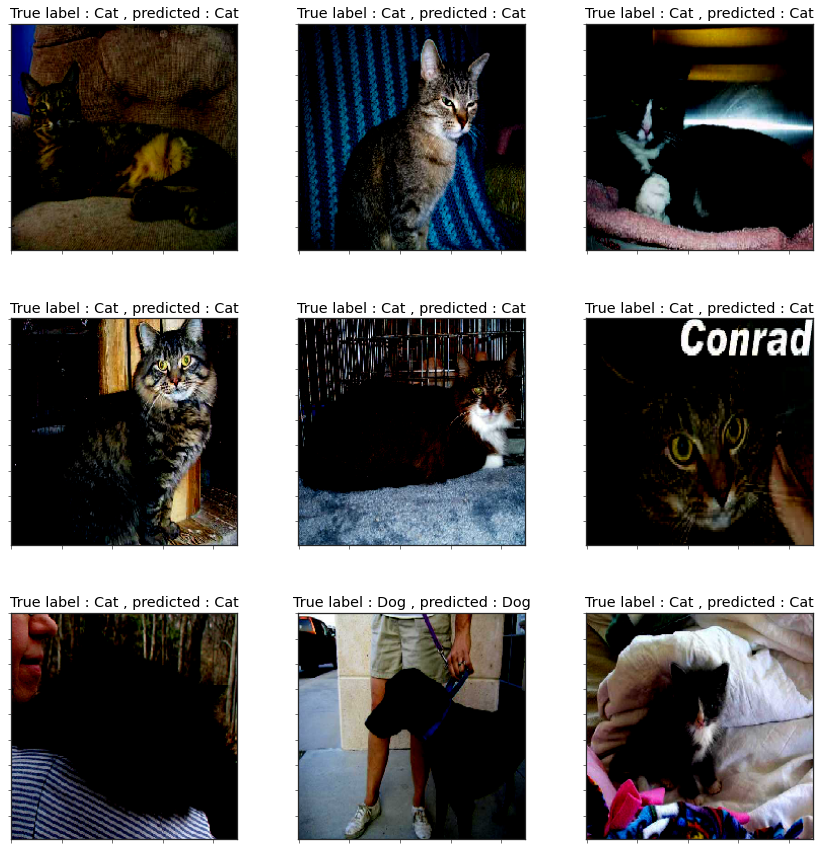

In [ ]:
plotClassified(X_test , prediction , y_testFlattened)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


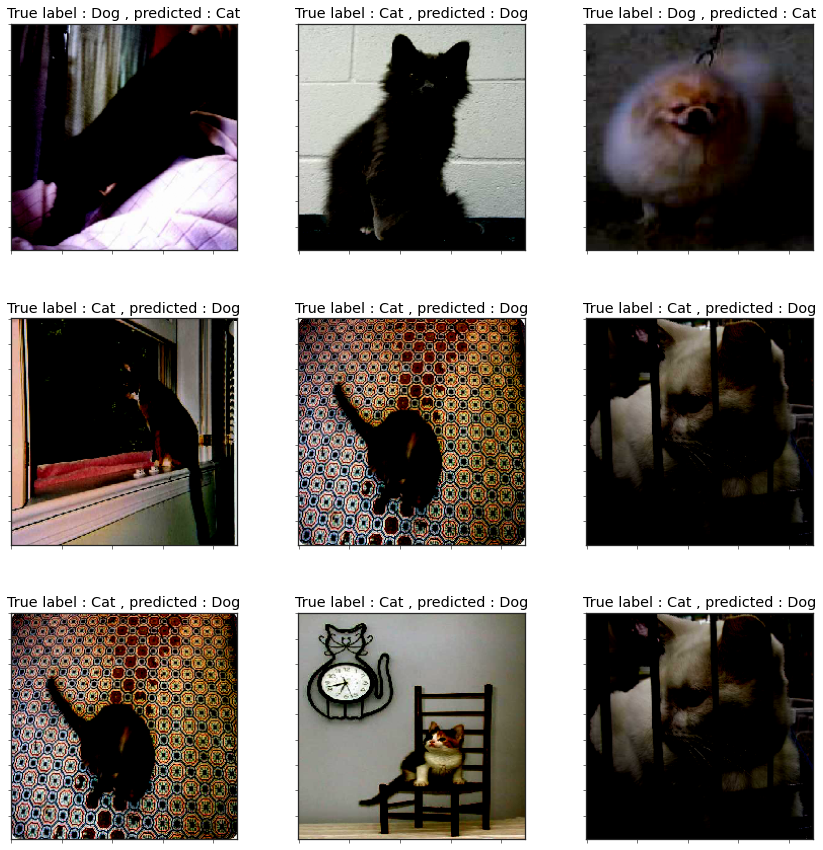

In [ ]:
plotMisclassified(X_test , prediction , y_testFlattened)